### DERNA/EDANN
### Diseño Evolutivo de Redes Neuronales Artificiales
### Evolutionary Design of Artificial Neural Networks

Universidad Central de Venezuela

Trabajo Especial de Grado de Maestría

Realizado por: Juan Manuel Acosta

Tutor: Prof. Dr. Haydemar Nuñez

Junio, 2021

Este programa permite el diseño evolutivo de redes neuronales artificiales.

Se proveen ejemplos de los casos más comunes, pero no está limitado a ellos, el analista puede agregar o modificar código según sus necesidades.

El analista debe configurar los hiperparámetros a optimizar y proveer el código (create_ann, prepare_data) para crear una Red Neuronal Artificial a partir de los hiperparámeros, preparar los datos, entrenar la red y evaluarla.

V 1.0 20200811 Reescritura completa de cero de DERNA, ahora usa genes reales, mapeo, alpha blend y mutación por perturbación gausiana.

V 1.1 20201021 Implementa tres tipos de genes: enteros, reales y ordinales.

V 1.2 20210512 Implementa TimeStopping, corrige bug en ordinales. Profundiza la modularización.

V 2.0 20210613 Se cambia la lectura del csv de Pandas a Numpy.

V 2.1 20210613 Primera prueba optimizando un hiperparámetro ordinal (el optimizador).

V 3.0 20210613 Ejemplo de un caso genérico. Se agregó control de precisión en hiperparámetros reales y se volvió a la lectura de datos en Pandas.

V 3.1 20210826 Ejemplo para optimizar las neuronas y seleccionar un indicador como entrada.

This program allows the evolutionary design of Artificial Neural Networks.

It has examples of the most common cases, but it is not limited to them, the analyst can add or modify code as needed.

The analyst must configure the hyperparameters and provide the code (create_ann, prepare_data) to create an Artificial Neural Network based on the hyperparameters, prepare the data, train the network and evaluate it.

V 1.0 20200811 Complete rewrite of DERNA, now it uses real genes, mapping, alpha blend, and Gaussian perturbation mutation.

V 1.1 20201021 It implements three types of genes: integer, real and ordinal.

V 1.2 20210512 Implements TimeStopping, fixes bug in ordinals. Deepens modularization.

V 2.0 20210613 The csv reading is changed from Pandas to Numpy.

V 2.1 20210613 First test optimizing an ordinal hyperparameter (the optimizer).

V 3.0 20210613 Example with a generic case. Added real precision control and returned to Pandas data reader.

V 3.1 20210826 Example to optimize neurons and select one indicator as input.


### Configuración
### Setup

#### Importar librerías y funciones
#### Import libraries and functions

In [ ]:
!pip install -U tensorflow-addons
!pip install -U deap
!pip install -U ta
import random
import datetime
from deap import creator, base, tools, algorithms
import pandas as pd
import numpy as np
import sklearn.preprocessing as skp
import ta
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

#### Hiperparámetros
#### Hyperparameters

In [ ]:
p = {
     # OPTIMIZADOR/OPTIMIZER
     'ngenes' : 2,  # número de genes en cada cromosoma
     # number of genes in each chromosome
     'genes' : ('Neurons', 'Indicator'),
     'min' : (5, 0),  # mínimo valor de cada gen
     # minimun value of each gene
     # 0 para los ordinales/ 0 for ordinals
     'max' : (30, 18),  # máximo valor de cada gen
     # maximum value of each gene
     'type' : ('I', 'O'),  # tipo de cada gen, I entero, Real, Ordinal
     # type of gene Integer, Real, Ordinal
     'values' : (0, ['Stochastic %K','Stochastic %D','Stochastic Slow %D',
                     'Gain','ROC','LW %R','ADO','MA5','MA10','Disparity 5',
                     'Disparity 10','OSCP','CCI','RSI','ADX','Momentum',
                     'MACD','MACD Histogram','MACD Signal']),
     # lista de valores para los genes ordinales o precisión para reales
     # list of values for ordinal genes or precision for reals
     # ['adamax','adam','nadam','sgd','adagrad','adadelta','rmsprop','ftrl']

     # RNA/ANN
     'Indicator': 'MACD',  # entrada seleccionada/selected input
     'Neurons': 9,  # neuronas escondidas/hidden layer neurons
     'activation': 'sigmoid',  # https://keras.io/api/layers/activations/
     # para la capa oculta/for the hidden layer
     'output_activation': 'linear',  # capa de salida/output layer
     'Window': 5, # ventana de promedio móvil/Simple Moving Average window
     'from_date': '1993-01-01',  # fecha desde
     'to_date': '2007-12-31',  # fecha hasta
     'dscaler': skp.MinMaxScaler(feature_range=(-1,1)),  # escalado data
     'tscaler': skp.MinMaxScaler(feature_range=(-1,1)),  # escalado targets
     'loss': 'mse',  # https://keras.io/api/losses/
     'optimizer': 'rmsprop', # https://keras.io/api/optimizers/
     'test_split': 0.20,  # 20% para prueba/20% for test data
     'val_split': 0.20,  # 20% for validación/20% for validation
     # las redes se comparan basado en la pérdida de validación
     # networks are compared based on validation loss
     'seconds': 5,  # límite de tiempo para entrenar/training time limit
     'epochs': 50,  # máximas rondas de entrenamiento/max training epochs
     'batch_size': 100,  # tamaño de lote
     'shuffle': False,  # los datos de entrenamiento/the training data
     # para series de tiempo normalmente debe ser False a menos que esten
     # desestacionalizadas
     # for time series normally False unless data has been atemporalized
     'verbose': 0,  # verbosidad del entrenamiento/verbose training

     # AG/GA
     'population' : 20,  # número de individuos en la población
     # debe escogerse basado en el tamaño del espacio a optimizar
     # entre más alto mejor cerca de sqrt(tamaño del espacio)
     # number of individuals in population
     # should be chosen based on the size of the optimization space
     # (better high around sqrt(space size))
     'ngen' : 5,  # número de generaciones (suficiente para que converga)
     # DERNA no hace evaluaciones redundantes, por lo que no es peligroso
     # un número alto
     # number of generations (just high enough)
     # EDANN does no redundant evaluations so a high value is not a problem
     'alpha' : 0.2,  # sobrepeso del alpha blend (no debe ser muy alto)
     # alpha blend oversize (better not too high)
     'sigma': 0.1,  # para la mutación gausiana
     # for gaussian mutation
     'indpb': 0.2,  # probabilidad individual para la mutación gausiana
     # individual probability for gaussian mutation
     'tournsize' : 3,  # tamaño del torneo
     # tournament size
     'cxpb' : 0.6,  # probabilidad de cruce (mejor alta)
     # crossover probability (better high)
     'mutpb' : 0.1,  # probabilidad de mutación (mejor baja)
     # mutation probability (better low)
    }

#### Carga de datos
#### Data load

In [ ]:
# copiar el archivo del repositorio
# copy file from repository
# el archivo de datos se puede crear con el programa 'Read data from Yahoo'
# this data file can be created with 'Read Data From Yahoo'
path_to_downloaded_file = tf.keras.utils.get_file(
    '^DJI.csv',
    'https://raw.githubusercontent.com/' +
    'jmacostap/webstore/master/^DJI.csv',
    cache_dir='/content',
    )
# cargar los datos en un dataframe
# load data into a Pandas dataframe
df = pd.read_csv(path_to_downloaded_file)
print(len(df), 'lines read')
print(df)

7466 lines read
            Date          Open  ...         Close     Volume
0     1992-01-02   3152.100098  ...   3172.399902   23550000
1     1992-01-03   3172.399902  ...   3201.500000   23620000
2     1992-01-06   3201.500000  ...   3200.100098   27280000
3     1992-01-07   3200.100098  ...   3204.800049   25510000
4     1992-01-08   3204.800049  ...   3203.899902   29040000
...          ...           ...  ...           ...        ...
7461  2021-08-16  35490.828125  ...  35625.398438  292590000
7462  2021-08-17  35500.011719  ...  35343.281250  309410000
7463  2021-08-18  35310.199219  ...  34960.691406  289800000
7464  2021-08-19  34874.671875  ...  34894.121094  333550000
7465  2021-08-20  34917.960938  ...  35120.078125  269545237

[7466 rows x 6 columns]


#### Preparación preliminar de los datos
#### Preliminary data preparation

Aquí se hace el preprocesamiento de datos que es independiente de los hiperparámetros optimizables

Data is preprocessing that is independent of optimizable hyperparameters

In [ ]:
# preparación de los datos independiente de los hiperparámetros a optimizar
# data preparation that is independent of optimizable hiperparameters

# limpia valores NAN, ceros y muy grandes
# clean NaN, zeros and too big values
df = ta.utils.dropna(df)
print('Original data read after dropping n/a')
print(df)

# encontrar el rango de fechas a usar
# find the date range to use
# date_range = (df['Date'] >= p['from_date']) & (df['Date'] <= p['to_date'])
for iloc_from in range(len(df['Date'])):
    if df['Date'].iloc[iloc_from] >= p['from_date']:
        break
p['iloc_from'] = iloc_from
for iloc_to in range(len(df['Date'])-1,-1,-1):
    if df['Date'].iloc[iloc_to] <= p['to_date']:
        break
p['iloc_to'] = iloc_to
# date_range = iloc_from:iloc_to

# encontrar el punto de corte
# find the split point
iloc_split = np.int((iloc_to - iloc_from + 1) * (1.0 - p['test_split']))
p['iloc_split'] = iloc_split

# df['Targets'] es la variable independiente
# df['Targets'] is the independent variable

# es muy importante que los datos esten debidamente compensados
# para que las predicciones esten dentro del rango y dominio de la RNA
# debe tomerse en cueta la tendencia a largo plazo, heterocedasticidad, etc.
# it is very important that data is properly compensated
# so the predictions are within the range and domain of the ANN
# long term tendency, heteroscedasticity, etc. must be accounted for

# rendimiento de mañana
# tomorrow's return
# df['Targets'] = ta.momentum.roc(df['Close'], 1).shift(-1)

# ganancia media de la semana que viene
# next week average gain
df['Targets'] = ta.momentum.roc(
    ta.trend.sma_indicator(df['Close'], 5), 5).shift(-5)

# ejemplo agregando todos los indicadores de ta
# example adding all ta features
'''
df = ta.add_all_ta_features(
    df, open='Open', high='High', low='Low',
    close='Close', volume='Volume', fillna=True)
'''

# ejemplos agregando indicadores específicos comunes
# examples adding common specific features
# df['Normal'] = (df['High'] + df['Low']) / 2
indicator = ta.momentum.StochasticOscillator(
    df['High'], df['Low'], df['Close'], window=14, smooth_window=3)
df['Stochastic %K'] = indicator.stoch()
df['Stochastic %D'] = indicator.stoch_signal()
df['Stochastic Slow %D'] = ta.trend.sma_indicator(df['Stochastic %D'], 3)
df['Gain'] = df['Close'] - df['Close'].shift(10)
df['ROC'] = df['Close'] / df['Close'].shift(10)
df['LW %R'] = ta.momentum.williams_r(
    df['High'], df['Low'], df['Close'], 14)
df['ADO'] = (df['High'] - df['Close'].shift(1)) / (df['High'] - df['Low'])
df['MA5'] = ta.trend.sma_indicator(df['Close'], 5)
df['MA10'] = ta.trend.sma_indicator(df['Close'], 10)
df['Disparity 5'] = 100 * df['Close'] / df['MA5']
df['Disparity 10'] = 100 * df['Close'] / df['MA10'] 
df['OSCP'] = (df['MA10'] - df['MA5']) / df['MA5']
df['CCI'] = ta.trend.cci(df['High'], df['Low'], df['Close'], 20, 0.015)
df['RSI'] = ta.momentum.rsi(df['Close'], 14) 
df['ADX'] = ta.trend.adx(df['High'], df['Low'], df['Close'], 14)
df['Momentum'] = ta.momentum.roc(df['Close'], 10)
indicator = ta.trend.MACD(df['Close'], 26, 12, 9)
df['MACD'] = indicator.macd()
df['MACD Histogram'] = indicator.macd_diff()
df['MACD Signal'] = indicator.macd_signal()

# rutinas auxiliares que no están en ta
# other routines that are not on ta
# trasponer una serie de tiempo para crear una ventana deslizante
# transposition of a time series to create a sliding window
# tf.keras.preprocessing.sequence.TimeseriesGenerator
# día de la semana
# weekday
# pd.Series.dt.weekday o pd.DatetimeIndex.weekday

# extraer solo las filas que se van a usar solo para mostrarlas
# los datos que realmente se usan vienen de prepare_data
# extract data that will be used only to show it here
# actual data used comes from prepare_data

df1 = df.drop(['Date','Open','High','Low','Close','Volume','MA5','MA10'],
              axis=1)[iloc_from:iloc_to]
print('\nPreprocessed data')
print(df1)

Original data read after dropping n/a
            Date          Open  ...         Close     Volume
0     1992-01-02   3152.100098  ...   3172.399902   23550000
1     1992-01-03   3172.399902  ...   3201.500000   23620000
2     1992-01-06   3201.500000  ...   3200.100098   27280000
3     1992-01-07   3200.100098  ...   3204.800049   25510000
4     1992-01-08   3204.800049  ...   3203.899902   29040000
...          ...           ...  ...           ...        ...
7461  2021-08-16  35490.828125  ...  35625.398438  292590000
7462  2021-08-17  35500.011719  ...  35343.281250  309410000
7463  2021-08-18  35310.199219  ...  34960.691406  289800000
7464  2021-08-19  34874.671875  ...  34894.121094  333550000
7465  2021-08-20  34917.960938  ...  35120.078125  269545237

[7466 rows x 6 columns]

Preprocessed data
       Targets  Stochastic %K  ...  MACD Histogram  MACD Signal
254  -1.079429      58.383559  ...       -1.943362    15.426128
255  -1.189479      57.140088  ...       -2.417731    14.8

/usr/local/lib/python3.7/dist-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/usr/local/lib/python3.7/dist-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


#### Preparación de los datos optimizados
#### Optimized data prepartion

Aqui se hace la preparación de los datos que depende de los hiperparámetros que se están optimizando.

Here goes the data preparation that is specific to the parameters being optimized.

In [ ]:


def prepare_data(p, df, test=False):
    '''Solo se usa si la preparación de los datos se está optimizando
    Prepara los datos y devuelve los datos de entrenamiento y los objetivos
    Only used if the data preparation is being optimized
    Prepare the data and return the training and targets data sets

    Args:
    p: dict: of hyperparametrs
    df: pandas.DataFrame: pre-processed data
    test: Bool: wether to return test data or not

    Returns:
    train_data: Numpy Array: train data
    train_targets: Numpy Array: train targets
    test_data: Numpy Array: test data
    test_targets: Numpy Array: test targets
    '''

    # aqui se recalculan las columnas de df según los valores de p
    # los parámetros a optimizar deben estar definidos en p
    # here columns are recalculated based on p values
    # the parameter to be optimized must be defined on p

    # extraer solo las filas que se van a usar
    # extract data that will be used
    df1 = df[['Targets', p['Indicator']]][p['iloc_from']:p['iloc_to']]

    train_targets = df1['Targets'].iloc[:p['iloc_split']].values.reshape(-1, 1)
    if test:
        test_targets = df1['Targets'].iloc[p['iloc_split']:].values.reshape(-1, 1)
    # drop targets from training data
    df1.drop(columns='Targets', inplace=True)
    train_data = df1.iloc[:p['iloc_split']].values

    # normalizar datos/normalize data
    data_scaler = p['dscaler']  # should fit only the train set
    train_data = data_scaler.fit_transform(train_data)
    targets_scaler = p['tscaler']  # they should be different instances
    train_targets = targets_scaler.fit_transform(train_targets)

    if test:
        test_data = df1.iloc[p['iloc_split']:].values
        test_data = data_scaler.transform(test_data)
        test_targets = targets_scaler.transform(test_targets)
        return train_data, train_targets, test_data, test_targets
    else:
        return train_data, train_targets



#### Creación de la RNA
#### ANN Creation

In [ ]:


def create_ann(p, df, time_stop=True):
    '''Crea una RNA con los parámetros de p y la entrena con train_data
    Create an ANN with the parameters on p and train it with train_data

    Args:
    p: dict: of hyperparameters
    df: pandas.DataFrame: pre-processed data
    time_stop: Bool: whether to make time stop or not

    Returns:
    ann: keras.model: the trained neural network
    history: keras.history: the training history
    '''

    # asegura reproducibilidad y consistencia
    # ensure reproducibility and consistency
    tf.random.set_seed(31416)  # keras

    # preparar los datos / prepare the data
    train_data, train_targets = prepare_data(p, df)

    # definir el modelo/define the model
    ann = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(
                p['Neurons'],
                activation=p['activation'],
            ),
            tf.keras.layers.Dense(
                units=1,
                activation=p['output_activation'],
            ),
        ]
    )

    # crear el modelo/create the model
    ann.compile(
        optimizer=p['optimizer'],
        loss=p['loss'],
    )


    # Entrenar el modelo/train the model
    if time_stop:
        time_stopping_callback = tfa.callbacks.TimeStopping(
            seconds=p['seconds'], verbose=1)
        callbacks = [time_stopping_callback]
    else:
        callbacks = None

    history = ann.fit(
        train_data,
        train_targets,
        epochs=p['epochs'],
        batch_size=p['batch_size'],
        verbose=p['verbose'],
        callbacks=callbacks,
        validation_split=p['val_split'],
        shuffle=p['shuffle'],
    )
    return ann, history



#### Crear y evaluar la RNA descrita por un cromosoma
#### Create and evaluate the ANN described by a chromosome

In [ ]:


def extract_phenotype(chromosome, p):
    '''Construye el fenotipo correspondiente a un genotipo/cromosoma
    Build the corresponding phenotype for a genotype/chromosome

    Args:
    chromosome: list: of genes. Each gene is a float that describes an
                ANN feature
    p: dict: of hyperparameters

    Returns:
    phenotype: tuple: of hyperparámeters
    '''

    phenotype_list=[]
    for i in range(p['ngenes']):
        if p['type'][i] == 'I':
            j = chromosome[i] * (p['max'][i] - p['min'][i] + 1) + p['min'][i]
            phenotype_list.append(int(j))
        elif p['type'][i] == 'R':
            j = chromosome[i] * (p['max'][i] - p['min'][i]) + p['min'][i]
            phenotype_list.append(round(j, p['values'][i]))
        else:
            j = chromosome[i] * (p['max'][i] + 1)
            phenotype_list.append(p['values'][i][int(j)])

    return tuple(phenotype_list)


def set_phenotype(phenotype, p):
    '''Fija los hiperparámetros en p según un fenotipo
    Set hyperparameters in p as per a phenotype

    Args:
    phenotype: tuple: of parameter values
    p: dict: of hiperparámeters

    Returns:
    p values set as per phenotype
    '''

    for i in range(p['ngenes']):
        p[p['genes'][i]] = phenotype[i]


def print_phenotype(phenotype, p):
    '''Muestra los valores de un fenotipo
    Pretty-print the values of a phenotype

    Args:
    phenotype: tuple: of hiperparámeters
    p: dict: of hiperparámeters

    Returns:
    Nothing
    '''

    for i, j in zip(p['genes'], phenotype):
        print('{}:{} '.format(i,j), end='')
    print('')


def evaluate_chromosome(chromosome, p, df, seen_phenotypes):
    '''Construir, entrenar y evaluar la RNA descrita por un cromosoma
    - Extraer el fenotipo del cromosoma
    - Si ya ha sido evaluado, devolver la pérdida inmediatamente
    - si no, crear la RNA, entrenarla y evaluarla
    - finalmente guardar los errores de entrenamiento y validación

    Build, train and evaluate the ANN represented by a chromosome
    - Extract the phenotype from the chromosome
    - If it has been previously evaluated return the loss immediately
    - otherwise create train and evaluate the ann
    - finally save the training and validation loss

    Args:
    chromosome: list: of genes. Each gene is a float that describes an
                ANN feature
    p: dict: of hyperparameters
    df: pandas.DataFrame: pre-processed data
    seen_phenotypes: dict: evaluated phenotypes and their losses

    Returns:
    (float,): Validation loss
    '''

    phenotype = extract_phenotype(chromosome, p)
    set_phenotype(phenotype, p)
    print_phenotype(phenotype, p)

    # evita evaluar de nuevo el mismo fenotipo
    # avoid evaluating the same phenotype twice
    if phenotype in seen_phenotypes:
        return seen_phenotypes[phenotype],

    # preprocesar los datos para este cromosoma específico
    # prepare dataset for this specific chromosome
    
    # construye la RNA
    # build the ANN
    model, history = create_ann(p, df)

    # extrae y despliega los errores
    # extract and display training and validation loss
    val_loss = history.history['val_loss'][-1]
    loss = history.history['loss'][-1]
    print('Training error: {} Validation error: {}'.format(loss, val_loss))

    # finalmente guarda el error
    # finally, save the loss
    seen_phenotypes[phenotype] = val_loss
    return val_loss,



#### Crea la definición de ajuste
#### Create the fitness definition

In [ ]:
# normalmente fitness trata de maximizar, se usa peso negativo para maximizar
# fitness normally tries to maximize we use negative weight to minimize

creator.create('FitnessMax', base.Fitness, weights=(1.0,))
creator.create('FitnessMin', base.Fitness, weights=(-1.0,))
creator.create('Individual', list, fitness=creator.FitnessMin)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


#### Definir el resto de los operadores genéticos en el toolbox
#### Define the rest of the genetic operators on the toolbox

In [ ]:
toolbox = base.Toolbox()
toolbox.register('attr_float', random.random)
toolbox.register('individual', tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=p['ngenes'])
toolbox.register('population', tools.initRepeat, list, toolbox.individual)


def checkBounds(min, max):
    '''Decorador para ajustar el valor del gen si se sale de rango
    Decorator to adjust the gene value in case it is out of bounds

    Args:
    min: minimum value
    max: maximum value

    Returns:
    The function that checks bounds to decorate mate or mutate on the toolbox
    '''


    def decorator(func):
        def wrapper(*args, **kargs):
            offspring = func(*args, **kargs)
            for child in offspring:
                for i in range(len(child)):
                    if child[i] > max:
                        child[i] = max
                    elif child[i] < min:
                        child[i] = min
            return offspring
        return wrapper
    return decorator


# cruce por AlphaBlend / mate by AlphaBlend
toolbox.register('mate', tools.cxBlend, alpha=p['alpha'])
# mantenerse dentro de [0,1) / stay within [0,1)
toolbox.decorate('mate', checkBounds(0.0, 0.99999999999999))
# mutación por perturbación gausiana / mutate by gaussian perturbation
toolbox.register('mutate', tools.mutGaussian, mu=0, sigma=p['sigma'],
                 indpb=p['indpb'])
# mantenerse dentro de [0,1) / stay within [0,1)
toolbox.decorate('mutate', checkBounds(0.0, 0.99999999999999))
toolbox.register('select', tools.selTournament, tournsize=p['tournsize'])
# evita repetir / seen list to avoid multiple evaluations
seen_phenotypes = {}
toolbox.register('evaluate', evaluate_chromosome, p=p, df=df,
                 seen_phenotypes=seen_phenotypes)

### El Algoritmo Genético
### The Genetic Algorithm

### Ejecuta el AG
#### Run the GA

In [ ]:
# siembra el generador aleatorio para asegurar reproducibilidad
# seed the random generator to ensure reproducibility
random.seed(31416) # DEAP/EDANN

seen_phenotypes.clear()

population = toolbox.population(n=p['population'])
log = algorithms.eaSimple(population, toolbox, cxpb=p['cxpb'],
                           mutpb=p['mutpb'], ngen=p['ngen'], verbose=True)

Neurons:18 Indicator:MACD Signal 
Training error: 0.03170916065573692 Validation error: 0.034564461559057236
Neurons:21 Indicator:MACD 
Training error: 0.031552985310554504 Validation error: 0.03448062390089035
Neurons:16 Indicator:RSI 
Training error: 0.028413623571395874 Validation error: 0.030567975714802742
Neurons:18 Indicator:RSI 
Training error: 0.02844676375389099 Validation error: 0.030593281611800194
Neurons:5 Indicator:MA10 
Training error: 0.03129475936293602 Validation error: 0.03306303545832634
Neurons:27 Indicator:CCI 
Training error: 0.027261221781373024 Validation error: 0.030472565442323685
Neurons:11 Indicator:OSCP 
Training error: 0.030611462891101837 Validation error: 0.032541923224925995
Neurons:14 Indicator:MACD Signal 
Training error: 0.0316649004817009 Validation error: 0.033982936292886734
Neurons:18 Indicator:Gain 
Training error: 0.028652284294366837 Validation error: 0.030730418860912323
Neurons:30 Indicator:Disparity 5 
Training error: 0.021736765280365944

#### Muestra las mejores soluciones
#### Show the best solutions

In [ ]:
best_individuals = tools.selBest(population, k=len(population))
# extraer los mejores fenotipos
# extract best phenotype
best_phenotype = extract_phenotype(best_individuals[0], p)
for chromosome in best_individuals:
    phenotype = extract_phenotype(chromosome, p)
    print_phenotype(phenotype, p)

Neurons:20 Indicator:Disparity 5 
Neurons:20 Indicator:Disparity 5 
Neurons:20 Indicator:Disparity 5 
Neurons:20 Indicator:Disparity 5 
Neurons:20 Indicator:Disparity 5 
Neurons:21 Indicator:Disparity 5 
Neurons:21 Indicator:Disparity 5 
Neurons:21 Indicator:Disparity 5 
Neurons:21 Indicator:Disparity 5 
Neurons:21 Indicator:Disparity 5 
Neurons:21 Indicator:Disparity 5 
Neurons:21 Indicator:Disparity 5 
Neurons:21 Indicator:Disparity 5 
Neurons:21 Indicator:Disparity 5 
Neurons:21 Indicator:Disparity 5 
Neurons:21 Indicator:Disparity 5 
Neurons:21 Indicator:Disparity 5 
Neurons:21 Indicator:Disparity 5 
Neurons:21 Indicator:Disparity 10 
Neurons:21 Indicator:Disparity 10 


#### Entrenar y probar al mejor individuo
#### Train the best individual and test it

In [ ]:
set_phenotype(best_phenotype, p)

# construir la RNA
# build the ANN
ann, history = create_ann(p, df, time_stop=False)

#### Despliegue gráfico del rendimiento de la RNA entrenada
#### Graphically display the performance of the trained ANN

##### Preparación de datos
##### Data preparation

In [ ]:
train_data, train_targets, test_data, test_targets  = prepare_data(p, df, True)

# es posible que se quiera reentrenar la RNA definitiva sin validación
# you may want to retrain the ANN without validation

test_loss = ann.evaluate(x=test_data,
    y=test_targets,
    batch_size=p['batch_size'])
train_pred = ann.predict(train_data)
test_pred = ann.predict(test_data)

# desplegar los errores de entrenamiento y validación
# display training and validation losses
print('Best ANN has: ', end='')
print_phenotype(best_phenotype, p)
print('Training loss: {:0.4f} Validation loss: {:0.4f} Test loss: {:0.4f}'.
      format(history.history['loss'][-1], history.history['val_loss'][-1],
             test_loss))
train_size = len(train_targets)
val_split = int((1.0-p['val_split']) * train_size)
total_size = train_size + len(test_targets)

8/8 [==============================] - 0s 2ms/step - loss: 0.0103
Best ANN has: Neurons:20 Indicator:Disparity 5 
Training loss: 0.0216 Validation loss: 0.0220 Test loss: 0.0103


##### Evolución del error de los primeros dos genes
##### Loss evolution of the first two genes

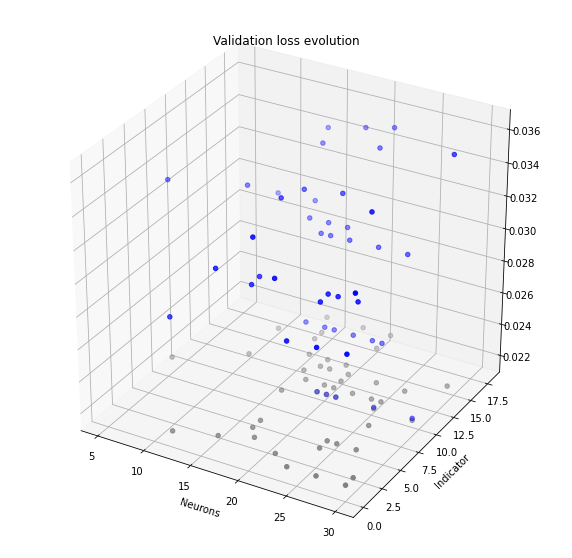

In [ ]:
# Neurons
x = np.array([i[0] for i in seen_phenotypes.keys()])
# Indicator
y = np.array([p['values'][1].index(i[1]) for i in seen_phenotypes.keys()])
# validation loss
z = np.array([i for i in seen_phenotypes.values()])
plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
#ax.plot_trisurf(x, y, z)
ax.scatter3D(x, y, z, c='Blue')
ax.scatter3D(x, y, min(z), c='Gray')  # sombras/shades
plt.title('Validation loss evolution')
plt.xlabel(p['genes'][0])
plt.ylabel(p['genes'][1])
#ax.view_init(elev=20)
plt.show()

##### Evolución del error durante el entrenamiento de la mejor RNA
##### Loss evolution during training of the best ANN

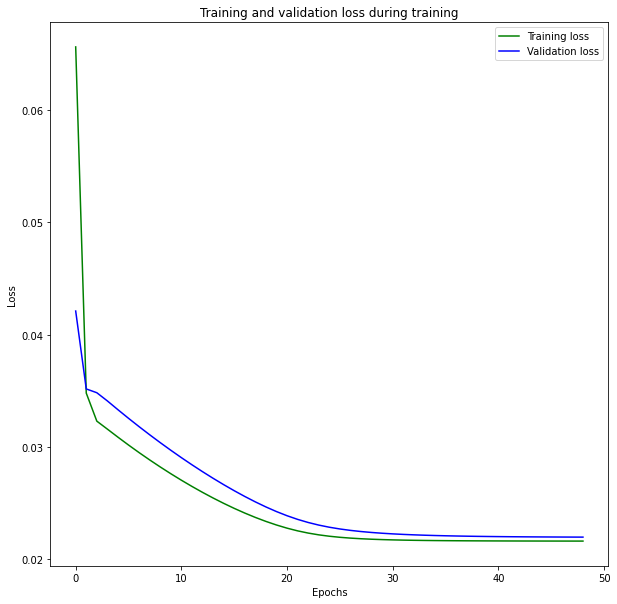

In [ ]:
skip = 1 
# si los primeros valores son muy altos se pueden eliminar
# del gráfico para evitar que afecten la escala automática
# avoid autoscale issues
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'][skip:], 'g',
            label='Training loss')
plt.plot(history.history['val_loss'][skip:], 'b',
            label='Validation loss')
plt.title('Training and validation loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

##### Datos originales y predicciones de la mejor RNA
##### Original data and predictions of the best ANN

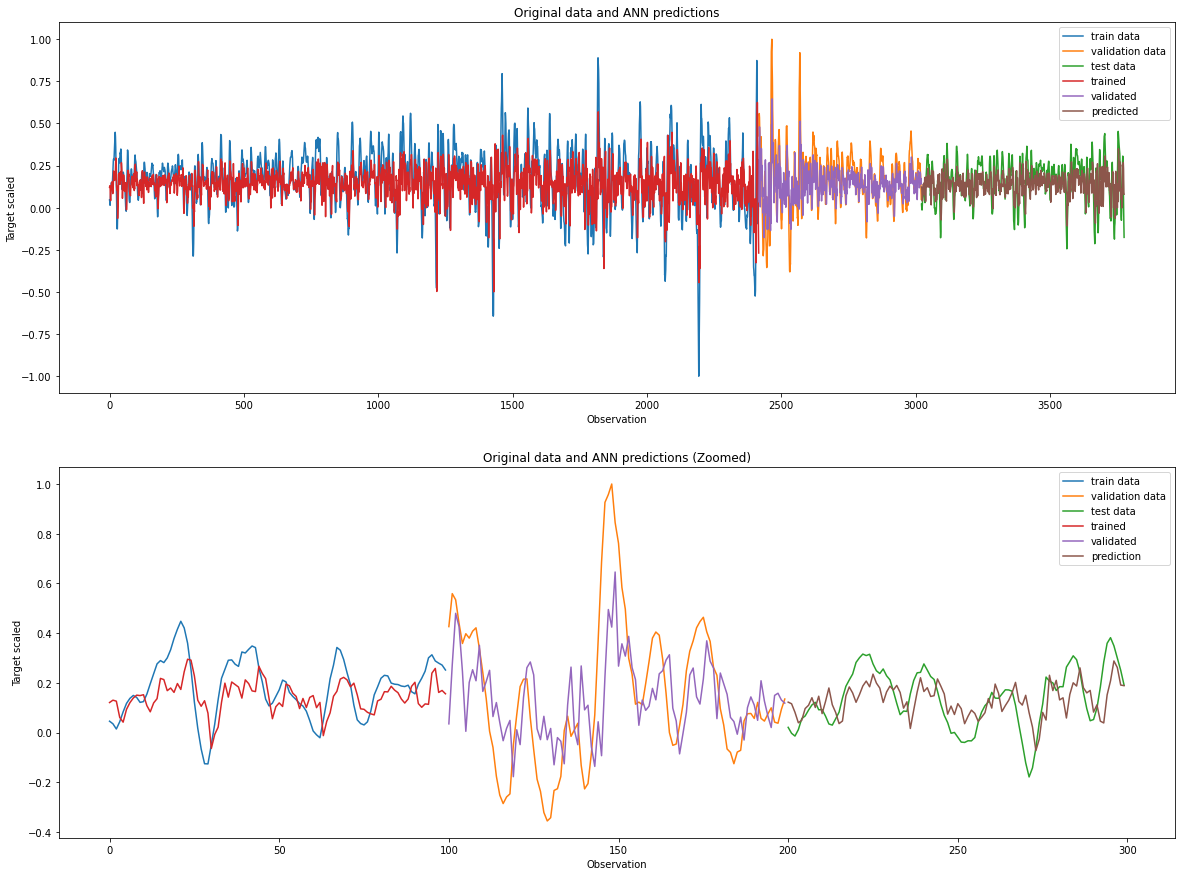

In [ ]:
plt.figure(figsize=(20, 15))
plt.subplot(2,1,1)
plt.plot(range(val_split), train_targets[:val_split], label='train data')
plt.plot(range(val_split, train_size), train_targets[val_split:],
         label='validation data')
plt.plot(range(train_size, total_size), test_targets, label='test data')
plt.plot(range(val_split), train_pred[:val_split], label='trained')
plt.plot(range(val_split, train_size), train_pred[val_split:],
         label='validated')
plt.plot(range(train_size, total_size), test_pred, label='predicted')
plt.title('Original data and ANN predictions')
plt.xlabel('Observation')
plt.ylabel('Target scaled')
plt.legend()

plt.subplot(2,1,2)
zoom_size=100
plt.plot(range(zoom_size), train_targets[:zoom_size], label='train data')
plt.plot(range(zoom_size, 2*zoom_size),
         train_targets[val_split:val_split+zoom_size], label='validation data')
plt.plot(range(2*zoom_size,3*zoom_size),
         test_targets[:zoom_size], label='test data')
plt.plot(range(zoom_size), train_pred[:zoom_size], label='trained')
plt.plot(range(zoom_size, 2*zoom_size),
         train_pred[val_split:val_split+zoom_size], label='validated')
plt.plot(range(2*zoom_size,3*zoom_size),
         test_pred[:zoom_size], label='prediction')
plt.title('Original data and ANN predictions (Zoomed)')
plt.xlabel('Observation')
plt.ylabel('Target scaled')
plt.legend()
plt.show()